# PRÁCTICA GUIADA: Model Validation Workflow

## Introducción

El objetivo de esta práctica es recorrer y profundizar las diferentes partes de la etapa de "Modelado" en el flujo de trabajo de Data Science. En efecto, supongamos que ya hemos concluido la etapa de limpieza y preprocesamiento de los datos. El paso siguiente es comenzar la etapa de análisis y modelado de la información. Hay tres grandes tareas que serán habitualmente realizadas en esta etapa (no excluyentes entre sí, de hecho será habitual encarar las tres en simultáneo):

* Realizar el proceso de tunning de los hiperparámetros
* Evaluar la performance de un modelo
* Evaluar la performance de varios modelos

A continuación presentamos un esquema estilizado del proceso:

#### Un esquema posible del proceso de estimación y modelado
_______________________________________________________________________________________________________________

1. Realizar una separación entre Train y Test Sets.

2. Sobre el **set de entrenamiento (Train Set):** 
    
    1. *Selección de los modelos a evaluar:* por ahora estamos trabajando sobre el de regresión modelo lineal y sus extensiones.
    
    2. *Proceso de Tunning de los Hiperparámetros:* hasta ahora hemos visto como primer hiperparámetro el $\alpha$ para los modelos de regresión regularizados. Este proceso se realiza generalmente a partir de una estrategia de cross-validation.
    
    3. *Entrenamiento del modelo final:* Luego del proceso de selección y tunning de los hiperparámetros, es necesario realizar el entrenamiento final del modelo. Para ello, estimamos un modelo sobre el total del Training Set.
    
3. Sobre el **set de testing (Test Set):**
       
    1. Estimación del error de genealización del mejor modelo 
________

En este LAB trabajaremos sobre estas diferentes etapas a partir de un dataset que busca modelar la progresión de la enfermedad diabetes. En efecto, el dataset contiene 10 variables fisiológicas (edad. sexo, índice de masa corporal y seis mediciones del plasma sanguíneo) medidas en 442 pacientes y un indicador de la progresión de la enfermedad luego de un año base.

La idea será hacer predicciones sobre este indicador de progresión de la enfermedad, identificando los mejores modelos y los mejores predictores.

Para ello, recorreremos los diferentes pasos de esta etapa.

* En primer lugar, como siempre, importamos los diferentes paquetes a utilizar.

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

* Luego, cargamos el dataset y definimos los nombres de colmnas

In [2]:
columns = "age sex bmi map tc ldl hdl tch ltg glu".split()
diabetes = datasets.load_diabetes()
df = pd.DataFrame(diabetes.data, columns=columns)
y = diabetes.target  # progresion de la enfermedad

df.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


* Pareciera que las variables ya están normalizadas. Lo verificamos:

In [3]:
df.apply(['mean','std']).T

,mean,std
age,-3.634285e-16,0.047619
sex,1.308343e-16,0.047619
bmi,-8.045349e-16,0.047619
map,1.281655e-16,0.047619
tc,-8.835316e-17,0.047619
ldl,1.327024e-16,0.047619
hdl,-4.574646e-16,0.047619
tch,3.777301e-16,0.047619
ltg,-3.830854e-16,0.047619
glu,-3.412882e-16,0.047619


* Efectivamente: 
    + $\bar{x_{j}} \approx 0$
    
    + $s_{j}=0.047619$
  
 
  
* Revisamos la descripción del dataset:

In [4]:
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

## Feature engineering: creamos features de grado 2

In [5]:
X = PolynomialFeatures(2,include_bias=False,interaction_only=False).fit_transform(df)
df.shape, X.shape

((442, 10), (442, 65))


## Paso 1. Hacer la separación entre Train Set y Test Set

Scikit-learn tiene una función que se encarga de la separación entre test y entrenamiento llamada `train_test_split`. El parámetro `test_size` indica la propoción de los datos que vamos a separar para hacer la evaluación.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=53)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(309, 65) (309,)
(133, 65) (133,)


## SOBRE EL TRAIN SET
### Paso 2A. Seleccionar los modelos a evaluar

En este ejercicio probaremos tres modelos diferentes:
    
* regresión lineal (`LinearRegression()`)
* regresión lineal regularizada Ridge (`Ridge()`, `RidgeCV()`)
* regresión lineal regularizada LASSO (`Lasso()`, `LassoCV()`)

Instanciemos, entonces, los modelos.

Ahora bien, vamos a realizar el proceso de tunning de los hiperparámetros de los modelos en base a validación cruzada. Por eso, instanciamos previamente tres objetos:

* un grid de diferentes valores $\alpha$ para realizar el tunning de Ridge (`al_ridge`)
* un grid de diferentes valores $\alpha$ para realizar el tunning de Lasso (`al_lasso`)
* un objeto que genera la partición del dataset en K partes para luego usar en el proceso de validación cruzada (`kf`). Al ejecutar `kf` el mismo provee los índices donde realizar el split del dataset. Notar que solamente instanciamos el `kf`. Luego, lo utilizaremos en la estimación de los hiperparámetros.

In [7]:
# Generamos un grid de $\alpha$ para probar e instanciamos un particionador del Training Set 
# en K partes para realizar la validación cruzada

al_ridge = np.linspace(0.001, 0.3, 300)
al_lasso = np.linspace(0.1, 0.5, 300)
kf = KFold(n_splits=5, shuffle=True, random_state=12)

# Instanciamos los modelos

lm = LinearRegression()
lm_ridge_cv= RidgeCV(alphas=al_ridge, cv=kf, normalize=False)
lm_lasso_cv = LassoCV(alphas=al_lasso, cv=kf, normalize=False)

* Luego, hacemos el fit de los tres estimadores, lo cual nos lleva a...

### Paso 2B. Proceso de Tunning de Hiperparámetros

In [8]:
# Hacemos los fits respectivos
lm.fit(X_train, y_train)
lm_ridge_cv.fit(X_train, y_train)
lm_lasso_cv.fit(X_train, y_train)

LassoCV(alphas=array([0.1       , 0.10133779, 0.10267559, 0.10401338, 0.10535117,
       0.10668896, 0.10802676, 0.10936455, 0.11070234, 0.11204013,
       0.11337793, 0.11471572, 0.11605351, 0.1173913 , 0.1187291 ,
       0.12006689, 0.12140468, 0.12274247, 0.12408027, 0.12541806,
       0.12675585, 0.12809365, 0.12943144, 0.13076923, 0.13210702,
       0.13344482, 0.13478261, 0.1361204 , 0.13745819, 0.13879599,
       0.140133...
       0.4812709 , 0.4826087 , 0.48394649, 0.48528428, 0.48662207,
       0.48795987, 0.48929766, 0.49063545, 0.49197324, 0.49331104,
       0.49464883, 0.49598662, 0.49732441, 0.49866221, 0.5       ]),
        copy_X=True, cv=KFold(n_splits=5, random_state=12, shuffle=True),
        eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

Es importante tener en claro que sucedió al ejecutar esta celda.

1. Hicimos un fit de un modelo de regresión lineal en el Training Set.
2. Usando `lm_ridge_cv`, realizamos el proceso de tunning del $\alpha$ en el modelo regularizado vía Ridge; a su vez, usamos el particionador `kf` con el que definimos que haríamos una Cross-Validation de K=5, haciendo un shuffle del dataset previamente.
3. Usando `lm_lasso_cv`, realizamos el tunning del $\alpha$ para el modelo LASSO (usando el mismo particionador `kf`)

Veamos cuáles son los $\alpha$ estimados:

In [9]:
print('Alpha Ridge:',lm_ridge_cv.alpha_,'\n'
      'Alpha LASSO:',lm_lasso_cv.alpha_,'\n')

Alpha Ridge: 0.004 
Alpha LASSO: 0.1 



### Paso 2C. Estimación del modelo final sobre todo el Training Set

Ya estamos en condiciones de realizar la estimación final de los modelos sobre los datos de Training Set, para luego realizar la validación final y seleccionar el modelo a utilizar.

El modelo de regresión lineal (al no tener hiperparámetros) ya está listo. Lo que nos queda es seleccionar los hiperparámetros $\alpha_{ridge}$ y $\alpha_{lasso}$ que minimicen los errores cross-validados respectivos. En este punto, podríamos ejecutar el siguiente código para el caso del modelo Ridge:

```python

a = lm_ridge_cv.alpha_
ridge_final = Ridge(a)
ridge_final.fit(X_train, y_train)
```

* Buscamos el $\alpha_{ridge}$ óptimo dentro del objeto `RidgeCV`.
* Instanciamos el estimador `Ridge`.
* Hacemos el fit. 

Con esto, tendríamos estimado el modelo, es decir... todos los parámetros, en este caso $\beta_{i}$ regularizados. Luego, repetiríamos el mismo proceso para Lasso. 

Afortunadamente, Scikit-Learn tiene implementado este procedimiento dentro de los mismos estimadores `RidgeCV` y `LassoCV`. De esta forma, ya se hizo el "fit" con el $\alpha$ mínimo en cada caso. Por esto, podemos llamar directamente al método `.predict` dentro de cada uno de los modelos.

En este [link](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) y en [este](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) pueden consultar más en profundidad sobre los estimadores en cuestión...

**NOTA:** Más adelante en el curso, veremos cómo "encapsular" estos procesos en un proceso más general que se llama [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), particularmente útil cuando tenemos muchos modelos a evaluar, con muchos hiperparámetros a tunear.

* Solamente por curiosidad, veamos qué performance tiene cada modelo en el Training Set.
* Calculemos el $R^2$ y el MSE.

In [10]:
# Calculamos el R2

print(" Score Train Lineal: %.2f\n" % lm.score(X_train, y_train),
      "Score Train Ridge : %.2f\n" % lm_ridge_cv.score(X_train, y_train),
      "Score Train Lasso : %.2f\n" %  lm_lasso_cv.score(X_train, y_train))

# Calculamos el RMSE

y_pred_tr_lm = lm.predict(X_train)
y_pred_tr_ridge = lm_ridge_cv.predict(X_train)
y_pred_tr_lasso = lm_lasso_cv.predict(X_train)

rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

print(" Train RMSE lineal   : %.2f \n" % rmse(y_train,y_pred_tr_lm),
      "Train RMSE Ridge    : %.2f \n" % rmse(y_train,y_pred_tr_ridge),
      "Train RMSE Lasso    : %.2f \n" % rmse(y_train,y_pred_tr_lasso))

 Score Train Lineal: 0.62
 Score Train Ridge : 0.55
 Score Train Lasso : 0.50

 Train RMSE lineal   : 46.42 
 Train RMSE Ridge    : 50.72 
 Train RMSE Lasso    : 53.39 



* ¿Cuáles son los parámetros de cada modelo?

In [11]:
np.set_printoptions(precision=3, suppress=True)

(lm.intercept_, lm.coef_)

(85.79953959962961,
 array([    51.889,   -277.931,    329.161,    408.838, -10879.143,
          9304.575,   4102.95 ,    398.192,   4159.891,     63.607,
          2934.339,   2601.91 ,  -2158.435,    748.513,  -6849.989,
          -291.786,   7406.615,   5535.134,   4594.689,     10.862,
            -1.678,   2429.966,   3543.026,   6127.881,  -5080.086,
         -1083.759,  -1358.331,  -2968.45 ,    215.523,   1343.784,
          2359.791, -18573.15 ,  18847.188,   2908.555,  -6154.991,
          6084.878,   1095.892,    111.728,  24379.253, -13336.511,
        -13497.03 ,  -8625.451,  -7366.977,  -4091.349,  47163.947,
        -62611.502, -32079.872, -34318.915, -24061.883,   6282.181,
         26112.234,  19995.948,  16280.057,   9985.092,  -6093.217,
          3403.824,  11381.295,  12233.682,   2976.084,   7801.497,
         12596.011,   5937.702,  21621.643,   -214.866,   1509.748]))

In [12]:
(lm_ridge_cv.intercept_,lm_ridge_cv.coef_)

(144.24560945671513,
 array([  25.376, -240.588,  473.598,  356.986, -569.13 ,  341.231,
         130.949,  287.821,  611.191,   27.374,  788.305,  951.323,
         -73.283,  506.988,   15.022, -192.054,   66.664,   17.361,
         516.83 ,  257.767,   -1.453,  441.846,  662.01 ,  121.68 ,
         -90.642,  364.671, -106.42 ,   12.284,  265.557,  590.469,
         424.759, -109.136,  -25.85 ,  -60.06 ,   87.101,  108.086,
         430.009,   59.725,  301.092,  382.578,  -83.078,   88.927,
         198.725, -149.219,  276.64 ,  308.553,  390.953, -401.704,
        -133.879,  410.752,  245.756,  142.038,   23.659,   29.135,
         326.068,  -88.096,  -77.162,  452.469,  316.232,   35.438,
        -525.554,   74.361,  -23.542,  236.016,  616.668]))

In [13]:
(lm_lasso_cv.intercept_,lm_lasso_cv.coef_)

(151.84474705120286,
 array([   0.   , -159.794,  490.66 ,  305.282,   -0.   ,   -0.   ,
        -181.009,   21.986,  441.617,    4.299,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,   -0.   ,    0.   ,
           0.   ,    0.   ,   -0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,   -0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,   -0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,   -0.   ,
          -0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,   -0.   ,   -0.   ,    0.   ,   -0.   ,    0.   ,
          -0.   ,    0.   ,   -0.   ,    0.   ,    0.   ]))

* ¿Cuáles son las variables más importantes?

## SOBRE TEST SET
### Paso 3. Hacer la estimación del error de generalización del modelo

Lo único que queda es evaluar la performance del modelo. Para ello debemos usar datos que no hayan formado parte del proceso de entrenamiento anterior. Usaremos, entonces, el Test Set.

In [14]:
# Hacemos las predicciones sobre la matriz de predictores del Test Set

y_pred_lm = lm.predict(X_test)
y_pred_ridge = lm_ridge_cv.predict(X_test)
y_pred_lasso = lm_lasso_cv.predict(X_test)


print(" Score Test Lineal: %.2f\n" % lm.score(X_test, y_test),
      "Score Test Ridge : %.2f\n" % lm_ridge_cv.score(X_test, y_test),
      "Score Test Lasso : %.2f\n" %  lm_lasso_cv.score(X_test, y_test))

# Testeo final del modelo sobre Test Set

print(" Test RMSE lineal= %.2f\n" % rmse(y_test, y_pred_lm),
      "Test RMSE Ridge = %.2f\n" %  rmse(y_test, y_pred_ridge),
      "Test RMSE Lasso = %.2f" %  rmse(y_test, y_pred_lasso))

 Score Test Lineal: 0.38
 Score Test Ridge : 0.53
 Score Test Lasso : 0.51

 Test RMSE lineal= 63.52
 Test RMSE Ridge = 55.21
 Test RMSE Lasso = 56.49


* ¿Con cuál se quedarían? ¿Cuál es el modelo que mejor performa? ¿Y el que peor?

```
 RMSE lineal= 63.52 (Train: 46.42)
 RMSE Ridge = 55.21 (Train: 50.72)
 RMSE Lasso = 56.49 (Train: 53.39)
```

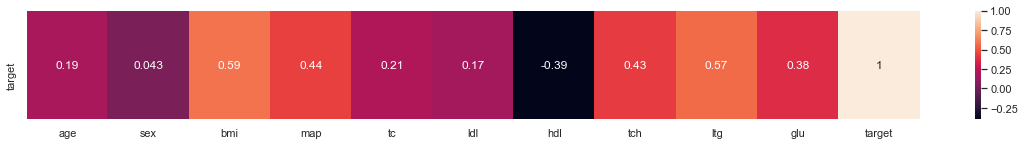

In [15]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,2)})
sns.heatmap(pd.concat([df, pd.DataFrame(y, columns=['target'])], axis=1).corr().iloc[[-1]], annot=True);

### Uso del parámetro **Stratify** en la función train-test split

In [16]:
df = pd.read_csv('../Data/salary.dat.txt', delim_whitespace=True)

In [17]:
df.head()

,sx,rk,yr,dg,yd,sl
0,male,full,25,doctorate,35,36350
1,male,full,13,doctorate,22,35350
2,male,full,10,doctorate,23,28200
3,female,full,7,doctorate,27,26775
4,male,full,19,masters,30,33696


In [18]:
df.shape

(52, 6)

In [19]:
# Creamos variables "dummy"

categories = ['sx', 'rk', 'dg']

for category in categories:
    serie = df[category]
    dummies = pd.get_dummies(serie, drop_first= True, prefix=category)
    df = pd.concat([df, dummies], axis=1)

df.head()

,sx,rk,yr,dg,yd,sl,sx_male,rk_associate,rk_full,dg_masters
0,male,full,25,doctorate,35,36350,1,0,1,0
1,male,full,13,doctorate,22,35350,1,0,1,0
2,male,full,10,doctorate,23,28200,1,0,1,0
3,female,full,7,doctorate,27,26775,0,0,1,0
4,male,full,19,masters,30,33696,1,0,1,1


In [20]:
# Creamos nuestra matriz de features y nuestro vector con la variable objetivo:

X = df.drop(['sx', 'rk', 'dg', 'sl'], axis=1)
y = df['sl']

Hacemos el split entre set de entrenamiento y de testeo:

In [21]:
# Hacemos un split entre train y test

X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                                    test_size=0.35, random_state=10)

In [22]:
print('Distribución en set de entrenamiento')
print(X_train['sx_male'].value_counts(normalize=True))
print('\n')
print('Distribución en set de testeo')
print(X_test['sx_male'].value_counts(normalize=True))

Distribución en set de entrenamiento
1    0.787879
0    0.212121
Name: sx_male, dtype: float64


Distribución en set de testeo
1    0.631579
0    0.368421
Name: sx_male, dtype: float64


Vemos que las clases no se distribuyen de la misma forma en ambos sets. Podemos usar el parámentro stratify para lograr que ambos sets tengan la misma distribución:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                                    test_size=0.35,\
                                                    stratify=X['sx_male'],\
                                                    random_state=10)

In [24]:
print('Distribución en set de entrenamiento')
print(X_train['sx_male'].value_counts(normalize=True))
print('\n')
print('Distribución en set de testeo')
print(X_test['sx_male'].value_counts(normalize=True))

Distribución en set de entrenamiento
1    0.727273
0    0.272727
Name: sx_male, dtype: float64


Distribución en set de testeo
1    0.736842
0    0.263158
Name: sx_male, dtype: float64


**Comentarios**:
    
  * Esta funcionalidad de la función de train-test split va a ser fundamental para hacer el split en problemas de clasificación cuando las clases están desbalanceadas. En ese caso vamos a pasar a la variable objetivo "y" como criterio de estratificación.
  * En el caso de aplicarlo a features, estratificar de acuerdo a una feature va a afectar la distribución de las demás, por lo que es un tema a tener en cuenta.
    